In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "D:\\MalariaDetection\\Cell_Images\\cell_images\\train"
test_path  = "D:\\MalariaDetection\\Cell_Images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=64, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=64, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
ConvNeXtTiny_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtTiny(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

ConvNeXtTiny_model.add(pretrained_model)

ConvNeXtTiny_model.add(Flatten())
ConvNeXtTiny_model.add(Dense(128, activation='relu'))
ConvNeXtTiny_model.add(Dense(1, activation='sigmoid'))

111650432/111650432 [==============================] - 15s 0us/step


In [11]:
ConvNeXtTiny_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,918,689
Trainable params: 98,561
Non-trainable params: 27,820,128
_________________________________________________________________


In [12]:
ConvNeXtTiny_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=12)

In [14]:
ConvNeXtTiny_model.fit(train_image_gen, epochs=60, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/60
390/390 [==============================] - 106s 236ms/step - loss: 0.2674 - accuracy: 0.8929 - val_loss: 0.2109 - val_accuracy: 0.9242
Epoch 2/60
390/390 [==============================] - 89s 227ms/step - loss: 0.2104 - accuracy: 0.9208 - val_loss: 0.2022 - val_accuracy: 0.9200
Epoch 3/60
390/390 [==============================] - 89s 227ms/step - loss: 0.1995 - accuracy: 0.9261 - val_loss: 0.1989 - val_accuracy: 0.9254
Epoch 4/60
390/390 [==============================] - 89s 227ms/step - loss: 0.1959 - accuracy: 0.9260 - val_loss: 0.2043 - val_accuracy: 0.9238
Epoch 5/60
390/390 [==============================] - 89s 227ms/step - loss: 0.1902 - accuracy: 0.9282 - val_loss: 0.1929 - val_accuracy: 0.9262
Epoch 6/60
390/390 [==============================] - 89s 228ms/step - loss: 0.1856 - accuracy: 0.9297 - val_loss: 0.2067 - val_accuracy: 0.9219
Epoch 7/60
390/390 [==============================] - 89s 229ms/step - loss: 0.1802 - accuracy: 0.9316 - val_loss: 0.1978 - val_a

In [15]:
history = pd.DataFrame(ConvNeXtTiny_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.267359,0.892900,0.210903,0.924231
1,0.210376,0.920787,0.202228,0.920000
2,0.199501,0.926076,0.198918,0.925385
3,0.195940,0.926036,0.204287,0.923846
4,0.190150,0.928159,0.192887,0.926154


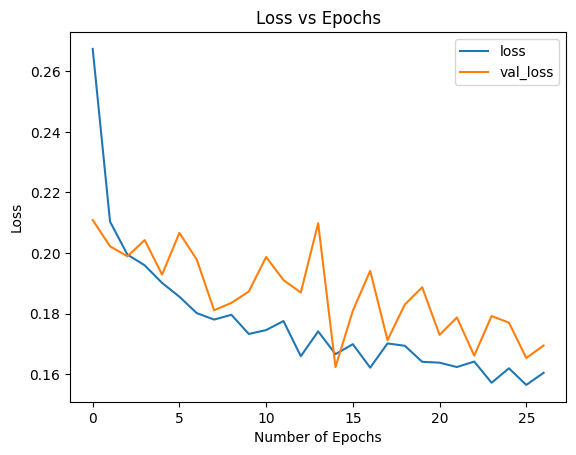

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsConNXtT.png')
plt.show()

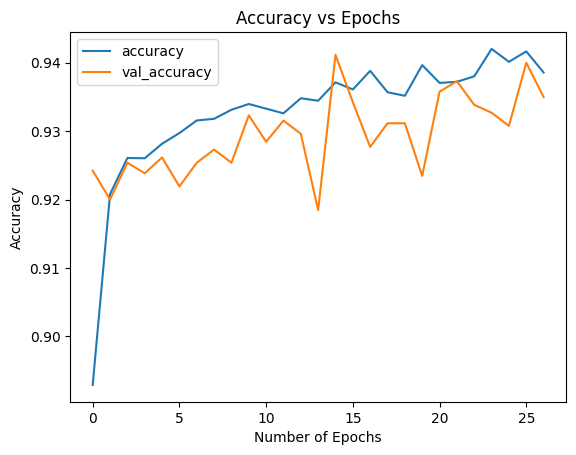

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsConNXtT.png')
plt.show()

In [19]:
predictions = ConvNeXtTiny_model.predict(test_image_gen)

41/41 [==============================] - 10s 200ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1300
           1       0.93      0.94      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1212,   88],
       [  74, 1226]], dtype=int64)

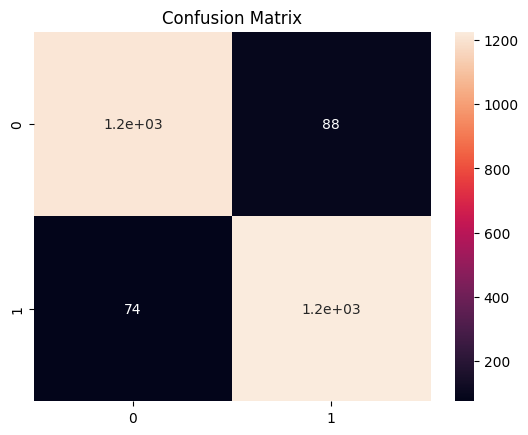

In [23]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapConNXtT.png')
plt.show()

In [24]:
ConvNeXtTiny_model.save("MalariaPredictionsConNXtT.h5")